# Training Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as T

from torchsummary import summary
from PIL import Image

import time

In [2]:
from data import CustomProcessedDataset
from models.net import ConvolutionNet
from models.training import train_model, test_model

In [3]:
import wandb
USE_WANDB = (input("Y/N? ").lower() == "y")
if USE_WANDB:
    wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dat-tht225482 (dat-tht225482-hust). Use `wandb login --relogin` to force relogin


#### A. Hyperparameters

In [4]:
MODEL_NAME = "convolution_net"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 200
FEATURES = 256
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
DROP_OUT = 0.2
IMAGE_SIZE = (224, 224)
CHECKPOINT_PATH = f"./models/{MODEL_NAME}_ckp.pth"
MODEL_PATH = f"./models/{MODEL_NAME}.pth"

In [5]:
mapper = {
    int(row["Target"]): str(row["Name"])
    for _, row in pd.read_csv("./data/processed/mapping.csv").iterrows()
}
NUM_CLASSES = len(mapper)
print(f"There are {NUM_CLASSES} classes")

There are 187 classes


In [6]:
if USE_WANDB:
    wandb.init(
        project="face-recognition",
        resume="allow",
        config={
            "model": MODEL_NAME,
            "num_classes": NUM_CLASSES,
            "hidden_features": FEATURES,
            "drop_out": DROP_OUT,
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE,
            "weight_decay": WEIGHT_DECAY,
            "device": DEVICE,
        },
    )

#### B. Import Preprocessed Dataset

##### Custom transform

In [7]:
class ImageAugmentation:
    def __init__(self):
        self.transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomRotation(10),
            T.RandomPerspective(0.2),
            T.RandomChoice([T.GaussianBlur(k) for k in [3, 5, 7]]),
            T.ColorJitter(brightness=(0.7, 1.3), contrast=(0.9, 1.1)),
        ])
    def __call__(self, image):
        return self.transform(image)


class PILToNormalizedTensor:
    def __init__(self):
        self.transform = T.Compose([
            T.ToImage(),
            T.ToDtype(torch.float32, scale=True),
        ])
    def __call__(self, image):
        return self.transform(image)

##### Visualize dataset

In [8]:
def visualize_dataset(dataset, mapper=None, rows=5, cols=5):
    figure = plt.figure(figsize=(10, 8))
    for i in range(1, cols * rows + 1):
        sample_idx = np.random.randint(len(dataset))
        img, target = dataset[sample_idx]
        img = np.asarray(img)
        if mapper:
            target = mapper[int(target)].replace("_", " ")
        figure.add_subplot(rows, cols, i)
        plt.title(target)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

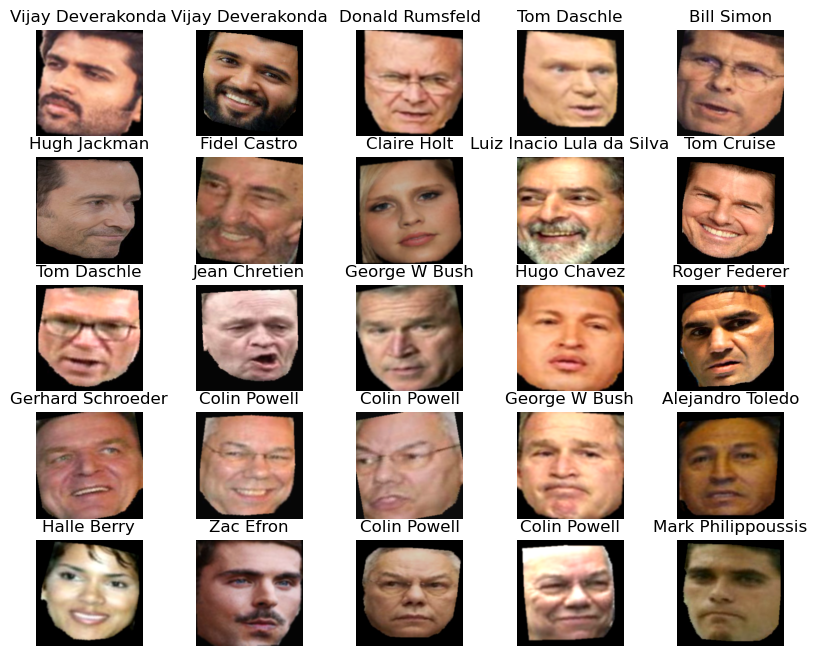

In [9]:
example_dataset = CustomProcessedDataset("./data/processed/train", ImageAugmentation())
visualize_dataset(example_dataset, mapper)

#### C. Model Architecture

In [10]:
model = ConvolutionNet(NUM_CLASSES, FEATURES, DROP_OUT).to(DEVICE)
summary(model, (3, 224, 224), device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
            Conv2d-3         [-1, 16, 224, 224]           2,320
              ReLU-4         [-1, 16, 224, 224]               0
   DoubleConvBlock-5         [-1, 16, 224, 224]               0
         MaxPool2d-6         [-1, 16, 111, 111]               0
            Conv2d-7         [-1, 32, 111, 111]           4,640
              ReLU-8         [-1, 32, 111, 111]               0
            Conv2d-9         [-1, 32, 111, 111]           9,248
             ReLU-10         [-1, 32, 111, 111]               0
  DoubleConvBlock-11         [-1, 32, 111, 111]               0
        MaxPool2d-12           [-1, 32, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]          18,496
             ReLU-14           [-1, 64,

#### D. Training

##### Dataloaders

In [11]:
transforms = T.Compose([ImageAugmentation(), PILToNormalizedTensor()])
train_dataset = CustomProcessedDataset("./data/processed/train", transform=transforms)
test_dataset = CustomProcessedDataset("./data/processed/test", transform=PILToNormalizedTensor())
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

##### Logging

In [12]:
def logging(use_wandb, epoch, train_loss, train_acc, test_loss, test_acc, time):
    time = int(time)
    logs = ""
    logs += f"Epoch {epoch}: "
    logs += f"Train Loss: {train_loss:.4f} | "
    logs += f"Train Accuracy: {train_acc:.2%} | "
    logs += f"Test Loss: {test_loss:.4f} | "
    logs += f"Test Accuracy: {test_acc:.2%} | "
    logs += f"Time Taken: {time // 60}m {time % 60:02d}s"
    if use_wandb:
        wandb.log(
            {
                "train_loss": train_loss,
                "train_acc": train_acc,
                "test_loss": test_loss,
                "test_acc": test_acc,
            }
        )
    print(logs, end=" ")

##### Training

In [13]:
def init_uniform_rule(m):
    if isinstance(m, nn.Linear):
        # get the number of the inputs
        n = m.in_features
        y = 1.0 / np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

model = ConvolutionNet(NUM_CLASSES, FEATURES, DROP_OUT).to(DEVICE)
model.apply(init_uniform_rule)
loss_fn = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [14]:
best_test_loss = float("inf")

if USE_WANDB:
    wandb.watch(model)

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    train_loss, train_acc = train_model(epoch, model, train_loader, loss_fn, optimizer, DEVICE)
    test_loss, test_acc = test_model(epoch, model, test_loader, loss_fn, DEVICE)
    time_taken = time.time() - start_time
    logging(USE_WANDB, epoch, train_loss, train_acc, test_loss, test_acc, time_taken)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        print("> Checkpoint saved!")
    else:
        print()

Epoch 1: Train Loss: 4.9880 | Train Accuracy: 7.66% | Test Loss: 4.8618 | Test Accuracy: 7.29% | Time Taken: 0m 24s > Checkpoint saved!
Epoch 2: Train Loss: 4.8386 | Train Accuracy: 7.68% | Test Loss: 4.8156 | Test Accuracy: 7.29% | Time Taken: 0m 17s > Checkpoint saved!
Epoch 3: Train Loss: 4.8101 | Train Accuracy: 7.70% | Test Loss: 4.7806 | Test Accuracy: 7.29% | Time Taken: 0m 17s > Checkpoint saved!
Epoch 4: Train Loss: 4.7374 | Train Accuracy: 8.16% | Test Loss: 4.6937 | Test Accuracy: 7.84% | Time Taken: 0m 18s > Checkpoint saved!
Epoch 5: Train Loss: 4.5924 | Train Accuracy: 9.61% | Test Loss: 4.4355 | Test Accuracy: 10.04% | Time Taken: 0m 17s > Checkpoint saved!
Epoch 6: Train Loss: 4.3838 | Train Accuracy: 11.78% | Test Loss: 4.2222 | Test Accuracy: 14.37% | Time Taken: 0m 17s > Checkpoint saved!
Epoch 7: Train Loss: 4.1948 | Train Accuracy: 14.08% | Test Loss: 4.0483 | Test Accuracy: 15.96% | Time Taken: 0m 17s > Checkpoint saved!
Epoch 8: Train Loss: 4.0176 | Train Accurac

In [15]:
if USE_WANDB:
    wandb.finish()
torch.save(model.state_dict(), MODEL_PATH)

test_acc,▁▂▃▄▅▆▆▇▇▇▇▇▇█▇█▇███████████████████████
test_loss,█▇▇▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▂▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███████████████
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,0.82393
test_loss,1.03467
train_acc,0.94616
train_loss,0.16585


In [18]:
from sklearn.metrics import classification_report

eval_model = ConvolutionNet(NUM_CLASSES, FEATURES, DROP_OUT).to(DEVICE)
eval_model.load_state_dict(torch.load("./models/convolution_net_1.pth", weights_only=True))
eval_model.eval()
eval_dataloader = DataLoader(test_dataset, num_workers=2)
predictions = []
actuals = []
for images, targets in eval_dataloader:
    images, targets = images.to(DEVICE), targets.to(DEVICE)
    # Get predition
    outputs = eval_model(images)
    probs = torch.exp(outputs)
    preds = probs.max(dim=1).indices
    predictions.append(preds.item())
    actuals.append(targets.item())

In [20]:
print(classification_report(
    actuals, predictions, 
    target_names=[mapper[i] for i in range(NUM_CLASSES)],
    zero_division=np.nan))

                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.75      0.86         4
             Adrien_Brody       1.00      0.67      0.80         3
             Akshay_Kumar       0.50      0.70      0.58        10
         Alejandro_Toledo       0.88      0.88      0.88         8
       Alexandra_Daddario       0.76      0.84      0.80        19
               Alia_Bhatt       0.82      0.88      0.85        16
             Alvaro_Uribe       0.88      1.00      0.93         7
          Amelie_Mauresmo       1.00      1.00      1.00         5
         Amitabh_Bachchan       0.75      1.00      0.86        15
             Andre_Agassi       0.89      1.00      0.94         8
             Andy_Roddick       0.67      0.67      0.67         3
             Andy_Samberg       1.00      0.79      0.88        19
           Angelina_Jolie       1.00      0.75      0.86         4
              Ann_Veneman       1.00      0.67      0.80     